Ilinca Bianca Mitrea Mitrea 100495772

David Mancebo Barrena 100495917

# 1.EDA

Importaciones previas

In [268]:
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler, RobustScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import balanced_accuracy_score, accuracy_score, confusion_matrix

## Número de variables e instancias

In [269]:
df = pd.read_csv("attrition_availabledata_08.csv")
print("Número de instancias:", df.shape[0])
print("Número de variables:", df.shape[1])


Número de instancias: 2940
Número de variables: 31


## Tipo de variables


Para identificar el tipo de cada variable en el dataset vamos a utilizar funciones de pandas.

In [270]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2940 entries, 0 to 2939
Data columns (total 31 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   hrs                      2940 non-null   float64
 1   absences                 2940 non-null   int64  
 2   JobInvolvement           2940 non-null   int64  
 3   PerformanceRating        2940 non-null   int64  
 4   EnvironmentSatisfaction  2923 non-null   float64
 5   JobSatisfaction          2928 non-null   float64
 6   WorkLifeBalance          2916 non-null   float64
 7   Age                      2940 non-null   int64  
 8   BusinessTravel           2940 non-null   object 
 9   Department               2940 non-null   object 
 10  DistanceFromHome         2940 non-null   int64  
 11  Education                2940 non-null   int64  
 12  EducationField           2940 non-null   object 
 13  EmployeeCount            2940 non-null   int64  
 14  EmployeeID              

In [271]:
# Seleccionar variables numéricas
numeric_vars = df.select_dtypes(include=['number'])
print("Variables numéricas:", numeric_vars.columns)
print("Número de variables numéricas:", len(numeric_vars.columns))

# Seleccionar variables categóricas
categorical_vars = df.select_dtypes(include=['object'])
print("Variables numéricas:", categorical_vars.columns)
print("Número de variables categóricas:", len(categorical_vars.columns))

Variables numéricas: Index(['hrs', 'absences', 'JobInvolvement', 'PerformanceRating',
       'EnvironmentSatisfaction', 'JobSatisfaction', 'WorkLifeBalance', 'Age',
       'DistanceFromHome', 'Education', 'EmployeeCount', 'EmployeeID',
       'JobLevel', 'MonthlyIncome', 'NumCompaniesWorked', 'PercentSalaryHike',
       'StandardHours', 'StockOptionLevel', 'TotalWorkingYears',
       'TrainingTimesLastYear', 'YearsAtCompany', 'YearsSinceLastPromotion',
       'YearsWithCurrManager'],
      dtype='object')
Número de variables numéricas: 23
Variables numéricas: Index(['BusinessTravel', 'Department', 'EducationField', 'Gender', 'JobRole',
       'MaritalStatus', 'Over18', 'Attrition'],
      dtype='object')
Número de variables categóricas: 8




De las 8 variables categóricas, se puede observar que una de ellas es ordinal. Por lo que:
Número de variables numéricas: 23

Número de variables categóricas: 8

Variables ordinales: BusinessTravel.

## Cardinalidad de las variables categóricas

In [272]:
cardinality = categorical_vars.nunique().sort_values(ascending=False)
print("Cardinalidad de cada variable categórica:")
print(cardinality)

Cardinalidad de cada variable categórica:
JobRole           9
EducationField    6
Department        3
BusinessTravel    3
MaritalStatus     3
Gender            2
Attrition         2
Over18            1
dtype: int64


Observamos que las variables con mayor cardinalidad son JobRole, con una cardinalidad de 9, y EducationField, con una cardinalidad de 6.


## Valores faltantes

Vamos a contar los valores faltantes.

In [273]:
# Contar valores faltantes en cada columna
missing_values = df.isnull().sum()

# Filtrar solo las variables que tienen valores faltantes
missing_values = missing_values[missing_values > 0]

print("Variables con valores faltantes y su cantidad:")
print(missing_values)

# Calcular el porcentaje de valores faltantes
missing_percentage = (df.isnull().sum() / len(df)) * 100

# Filtrar solo las columnas que tienen valores faltantes
missing_percentage = missing_percentage[missing_percentage > 0]

print("\nPorcentaje de valores faltantes por variable:")
print(missing_percentage.sort_values(ascending=False))


Variables con valores faltantes y su cantidad:
EnvironmentSatisfaction    17
JobSatisfaction            12
WorkLifeBalance            24
NumCompaniesWorked         11
TotalWorkingYears           4
dtype: int64

Porcentaje de valores faltantes por variable:
WorkLifeBalance            0.816327
EnvironmentSatisfaction    0.578231
JobSatisfaction            0.408163
NumCompaniesWorked         0.374150
TotalWorkingYears          0.136054
dtype: float64


Observamos que el porcentaje de valores faltantes es bajo, por lo que podríamos simplemente eliminarlos o usar imputación básica.

## Columnas constantes e identificadores

In [274]:
# Contar valores únicos por columna
constant_cols = df.nunique()[df.nunique() == 1]

print("Columnas constantes:")
print(constant_cols)

# Contar valores únicos en cada columna y compararlos con el número de filas
id_cols = df.nunique()[df.nunique() == df.shape[0]]

print("\nColumnas de ID:")
print(id_cols)


Columnas constantes:
EmployeeCount    1
Over18           1
StandardHours    1
dtype: int64

Columnas de ID:
EmployeeID    2940
dtype: int64


## Tipo de problema

En este caso, la variable Attrition indica si un empleado renuncia, por lo que es un problema de clasificación.

## Desbalanceo de datos


In [275]:
# Contar las instancias por cada clase
conteo = df['Attrition'].value_counts()
print("Conteo por clase:")
print(conteo)

# Calcular el porcentaje de cada clase
porcentajes = df['Attrition'].value_counts(normalize=True) * 100
print("\nPorcentaje por clase:")
print(porcentajes)

Conteo por clase:
Attrition
No     2466
Yes     474
Name: count, dtype: int64

Porcentaje por clase:
Attrition
No     83.877551
Yes    16.122449
Name: proportion, dtype: float64


También podemos visualizar la distribución con un gráfico de barras

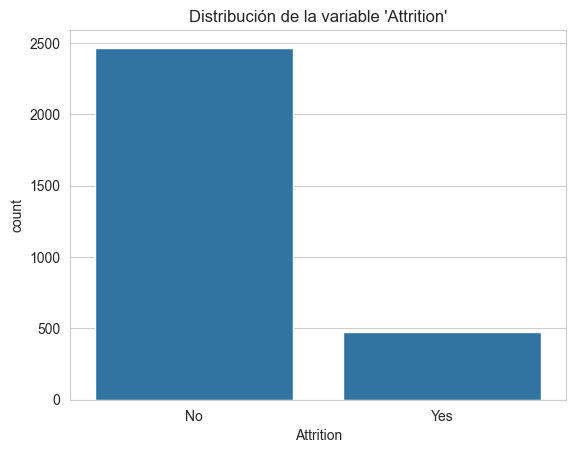

In [276]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(x='Attrition', data=df)
plt.title("Distribución de la variable 'Attrition'")
plt.show()


Sí, el dataset está desbalanceado porque la clase mayoritaria ("No" - empleados que no abandonan la empresa) representa el 83.88% de los datos, mientras que la clase minoritaria ("Yes" - empleados que abandonan la empresa) solo representa el 16.12%.
Podríamos usar SMOTE para aumentar la clase minoritaria (oversampling)


# 2. Preprocesamiento de datos

Según las diapositivas de clase el preproceso tiene las siguientes fases en general:

Instancias:
1. Quitar datos ruidosos (Wilson editing rule) (sobre todo para KNN)
2. Quitar datos redundantes (Condensación, sobre todo para KNN)
3. Re-balanceo en problemas de clase desbalanceada: oversampling,
undersampling, SMOTE – Synthetic Minority Over-sampling Technique, …

Atributos:
1. Escalado/Normalización (MinMax, Standard, Robust)
2. Quitar atributos constantes
3. Imputación (¿qué hacer con valores faltantes (missing values))?
4. Codificación de atributos categóricos (one-hot-encoding/dummy variables,
codificación ordinal, alta cardinalidad, …)
5. Selección de atributos
6. Transformación de atributos (PCA, ...) "

Vamos a hacer el preproceso de datos mediante un pipeline para evitar information leakage.

Usaremos un pipeline de preprocesamiento que incluya:

- Encoding (One-Hot y Label/Ordinal Encoding según corresponda)
- Imputación de valores faltantes

Esto asegurará que el preprocesamiento se realice de manera consistente en train y test, evitando errores y asegurando reproducibilidad.

Pero antes de hacer el pipeline, podemos hacer:
- Eliminación de atributos constantes
- Eliminación de identificadores

Se pueden realizar una sola vez antes del entrenamiento y no necesitan ajustes posteriores.

## Eliminar atributos constantes e identificadores

Ya hemos visto previamente que tenemos 3 columnas constantes y una columna ID.

In [277]:
original_columns = set(df.columns)

id_columns = ['EmployeeID'] 
df = df.drop(columns=id_columns, errors='ignore')

# Eliminar columnas constantes
constant_columns = [col for col in df.columns if df[col].nunique() <= 1]
df = df.drop(columns=constant_columns, errors='ignore')

# Mostrar las columnas eliminadas
removed_columns = original_columns - set(df.columns)
if removed_columns:
    print("Columnas eliminadas:")
    print(list(removed_columns))
else:
    print("No se eliminaron columnas.")

Columnas eliminadas:
['StandardHours', 'Over18', 'EmployeeCount', 'EmployeeID']


## Encoding

In [278]:
# Identificar variables categóricas
categorical_cols = df.select_dtypes(include=['object']).columns
print("Variables categóricas:", categorical_cols)

Variables categóricas: Index(['BusinessTravel', 'Department', 'EducationField', 'Gender', 'JobRole',
       'MaritalStatus', 'Attrition'],
      dtype='object')


Vamos a identificar las variables ordinales dentro de las variables categóricas para determinar qué tipo de encoding haremos para cada una.

In [279]:
# Valores únicos por cada variable categórica
for col in categorical_cols:
    print(f"\n{col}:")
    print(df[col].unique())



BusinessTravel:
['Non-Travel' 'Travel_Frequently' 'Travel_Rarely']

Department:
['Research & Development' 'Sales' 'Human Resources']

EducationField:
['Other' 'Marketing' 'Life Sciences' 'Technical Degree' 'Medical'
 'Human Resources']

Gender:
['Female' 'Male']

JobRole:
['Research Scientist' 'Manufacturing Director' 'Healthcare Representative'
 'Sales Executive' 'Manager' 'Laboratory Technician' 'Research Director'
 'Sales Representative' 'Human Resources']

MaritalStatus:
['Divorced' 'Married' 'Single']

Attrition:
['No' 'Yes']


Vemos que todas son categóricas, excepto BusinessTravel que es ordinal porque tiene un orden implícito. Attrition y gender pueden tratarse como variables binarias.

Para variables ordinales: usamos Label Encoding

Para variables nominales: usamos One-Hot Encoding

Para variables binarias: convertimos a 0 y 1


In [280]:
# Identificar columnas categóricas y numéricas

all_categorical = df.select_dtypes(include=['object']).columns.tolist()

# Remover la variable target, si se detecta entre las categóricas
target = 'Attrition'
if target in all_categorical:
    all_categorical.remove(target)
    
# Definimos la variable ordinal
ordinal_cols = ['BusinessTravel']

# Las columnas nominales serán las categóricas menos las ordinales
categorical_cols = [col for col in all_categorical if col not in ordinal_cols]

numerical_cols = df.select_dtypes(include=['number']).columns.tolist()


# Imprimir resultados para verificar
print("Number of ordinal columns:", len(ordinal_cols))
print("Ordinal columns:", ordinal_cols)
for col in ordinal_cols:
    # Obtener valores únicos y ordenarlos
    ordinal_values = [sorted(df[col].dropna().unique()) for col in ordinal_cols]
    print("Values of ", ordinal_cols, ": ", ordinal_values)
print("Number of nominal columns:", len(categorical_cols))
print("Nominal columns:", categorical_cols)
print("Number of numerical columns:", len(numerical_cols))
print("Numerical columns:", numerical_cols)

Number of ordinal columns: 1
Ordinal columns: ['BusinessTravel']
Values of  ['BusinessTravel'] :  [['Non-Travel', 'Travel_Frequently', 'Travel_Rarely']]
Number of nominal columns: 5
Nominal columns: ['Department', 'EducationField', 'Gender', 'JobRole', 'MaritalStatus']
Number of numerical columns: 20
Numerical columns: ['hrs', 'absences', 'JobInvolvement', 'PerformanceRating', 'EnvironmentSatisfaction', 'JobSatisfaction', 'WorkLifeBalance', 'Age', 'DistanceFromHome', 'Education', 'JobLevel', 'MonthlyIncome', 'NumCompaniesWorked', 'PercentSalaryHike', 'StockOptionLevel', 'TotalWorkingYears', 'TrainingTimesLastYear', 'YearsAtCompany', 'YearsSinceLastPromotion', 'YearsWithCurrManager']


Esta información nos servirá para la parte de encoding dentro de la definición de pipeline que utilizaremos en el preprocesamiento.

## Imputación

La imputación se debe hacer solo con los datos de entrenamiento, ya que los datos de test son datos del futuro y, por tanto, debemos suponer que no los conocemos para evitar information leakage o fuga de información. 

Para hacer imputación cuando puede ocurrir information leakage, lo correcto es construir un pipeline.

Si tenemos que imputar los atributos del conjunto de test, usaremos las medias o mediana calculadas con el conjunto de entrenamiento (reimputación), para evitar fuga de información del conjunto de test.

In [281]:
# Valores faltantes en variables numéricas
num_missing = df[numerical_cols].isnull().sum()
num_missing_percent = (num_missing / len(df)) * 100

# Filtrar solo las columnas con valores faltantes
missing_numerical = pd.DataFrame({
    'Missing Count': num_missing,
    'Missing Percent': num_missing_percent
}).query('`Missing Count` > 0').sort_values(by='Missing Count', ascending=False)

print("Valores faltantes en variables numéricas:")
if not missing_numerical.empty:
    print(missing_numerical)
else:
    print("No hay valores faltantes en variables numéricas.")

# Valores faltantes en variables categóricas nominales
missing_nominal = df[categorical_cols].isnull().sum()
missing_nominal_percent = (missing_nominal / len(df)) * 100

# Filtrar solo las columnas con valores faltantes
missing_nominal_df = pd.DataFrame({
    'Missing Count': missing_nominal,
    'Missing Percent': missing_nominal_percent
}).query('`Missing Count` > 0').sort_values(by='Missing Count', ascending=False)

print("\nValores faltantes en variables categóricas nominales:")
if not missing_nominal_df.empty:
    print(missing_nominal_df)
else:
    print("No hay valores faltantes en variables categóricas nominales.")

# Valores faltantes en variables ordinales
missing_ordinal = df[ordinal_cols].isnull().sum()
missing_ordinal_percent = (missing_ordinal / len(df)) * 100

# Filtrar solo las columnas con valores faltantes
missing_ordinal_df = pd.DataFrame({
    'Missing Count': missing_ordinal,
    'Missing Percent': missing_ordinal_percent
}).query('`Missing Count` > 0').sort_values(by='Missing Count', ascending=False)

print("\nValores faltantes en variables ordinales:")
if not missing_ordinal_df.empty:
    print(missing_ordinal_df)
else:
    print("No hay valores faltantes en variables ordinales.")


Valores faltantes en variables numéricas:
                         Missing Count  Missing Percent
WorkLifeBalance                     24         0.816327
EnvironmentSatisfaction             17         0.578231
JobSatisfaction                     12         0.408163
NumCompaniesWorked                  11         0.374150
TotalWorkingYears                    4         0.136054

Valores faltantes en variables categóricas nominales:
No hay valores faltantes en variables categóricas nominales.

Valores faltantes en variables ordinales:
No hay valores faltantes en variables ordinales.


Tenemos valores faltantes solo en variables numéricas. Además, con porcentajes muy bajos (menos de 1% en cada una), por lo que el problema es leve. Se considerarán la media y la mediana para imputar los valores numéricos faltantes.

Aunque en nuestro dataset no tenemos valores faltantes en atributos categóricos y ordinales, vamos a utilizar imputación mediante moda para estas variables (ya que no toman valores numéricos, no podemos usar mediana ni media). Esto nos da mayor flexibilidad y robustez por si nuestro dataset cambia en un futuro.


## Escalado

Variables numéricas como Age, MonthlyIncome, DistanceFromHome, etc., pueden tener escalas muy diferentes y para modelos como KNN es importante escalar estas variables para dar la misma importancia a todas las variables. Por si acaso, vamos a escalar también las variables categóricas y ordinales después del encoding. Se considerarán tres métodos de escalado (minmax, standard, robust).



## Estrategia


1. Imputación en variables numéricas:
Probar dos estrategias:

- Media
- Mediana

2. Escalado en variables numéricas (y en general en el conjunto transformado):
Evaluar tres métodos:

- StandardScaler
- MinMaxScaler
- RobustScaler

3. Usar un pipeline que incluya el preprocesamiento (imputación y encoding) y el escalado, seguido de un clasificador KNN.

4. Aplicar GridSearchCV para explorar las combinaciones de imputador y escalador utilizando una métrica como balanced accuracy.

In [282]:
# SEPARACIÓN ENTRE VARIABLES Y DIVISIÓN TRAIN/TEST
X = df.drop(columns=['Attrition'])
y = df['Attrition']


# Encoding de la variable de decisión
# TODO: duda aquí ??
y = y.map({'No': 0, 'Yes': 1})

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=1/3, random_state=72, stratify=y
)

print(f"Tamaño de Train: {X_train.shape}, Tamaño de Test: {X_test.shape}")


Tamaño de Train: (1960, 26), Tamaño de Test: (980, 26)


In [283]:
from sklearn.model_selection import KFold

# Para variables numéricas: imputación con mediana y escalado
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())  # se parametrizará en GridSearch
])

# Para variables categóricas nominales: One-Hot Encoding
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore', drop='first'))
])

# Para variables ordinales: OrdinalEncoder con el orden definido
ordinal_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OrdinalEncoder(categories=ordinal_values))
])

# COMBINACIÓN DE TRANSFORMACIONES (AÚN SIN ESCALADO)
preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, numerical_cols),
    ('cat', categorical_transformer, categorical_cols),
    ('ord', ordinal_transformer, ordinal_cols)
])

# PIPELINE GLOBAL: PRIMERO TRANSFORMACIÓN, LUEGO ESCALADO
pipeline = Pipeline(steps=[
    ('preprocessing', preprocessor),  # Primero se hace imputación y encoding
    #('scaler', StandardScaler()),
    ('classifier', KNeighborsClassifier())
])

# Definir la grilla de parámetros para el GridSearchCV:
param_grid = {
    # Imputación: 'mean' o 'median' para variables numéricas
    'preprocessing__num__imputer__strategy': ['mean', 'median'],
    # Escalado: probar MinMaxScaler, StandardScaler y RobustScaler
    'preprocessing__num__scaler': [MinMaxScaler(), StandardScaler(), RobustScaler()],
}

# Configurar GridSearchCV usando balanced_accuracy como métrica (dado el desbalanceo)
inner = KFold(n_splits=5, shuffle=True, random_state=72)
grid_search = GridSearchCV(pipeline, param_grid, cv=inner, scoring='balanced_accuracy', n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)

best_preprocessor = grid_search.best_estimator_ # mejor model del INNER LOOP

# Extraer los inner scores de GridSearchCV
inner_scores = pd.DataFrame(grid_search.cv_results_)

# Seleccionar solo las columnas clave
inner_scores = inner_scores[
    ['param_preprocessing__num__imputer__strategy',
     'param_preprocessing__num__scaler',
     'mean_test_score', 'std_test_score', 'rank_test_score']
]

# Ordenar por la mejor precisión balanceada
inner_scores = inner_scores.sort_values(by='mean_test_score', ascending=False)

# Mostrar resultados
print("Resultados de Validación Cruzada (INNER LOOP)")
display(inner_scores)

print("Mejor combinación de parámetros:")
print(grid_search.best_params_)
print("Mejor Balanced Accuracy (CV):", grid_search.best_score_)



Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 5/10] END metric=euclidean, n_neighbors=2, p=3, weights=uniform;, score=0.561 total time=   0.0s
[CV 1/10] END metric=euclidean, n_neighbors=2, p=3, weights=distance;, score=0.854 total time=   0.0s
[CV 5/10] END metric=euclidean, n_neighbors=2, p=3, weights=distance;, score=0.781 total time=   0.0s
[CV 7/10] END metric=manhattan, n_neighbors=2, p=3, weights=distance;, score=0.904 total time=   0.1s
[CV 8/10] END metric=manhattan, n_neighbors=2, p=3, weights=distance;, score=0.748 total time=   0.1s
[CV 9/10] END metric=manhattan, n_neighbors=2, p=3, weights=distance;, score=0.888 total time=   0.1s
[CV 10/10] END metric=manhattan, n_neighbors=2, p=3, weights=distance;, score=0.801 total time=   0.1s
[CV 7/10] END metric=manhattan, n_neighbors=4, p=3, weights=distance;, score=0.904 total time=   0.1s
[CV 8/10] END metric=manhattan, n_neighbors=4, p=3, weights=distance;, score=0.748 total time=   0.1s
[CV 9/10] END metric=m

/Users/ilimi/PycharmProjects/P1-Machine-Learning/.venv/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV 4/10] END metric=euclidean, n_neighbors=2, p=3, weights=uniform;, score=0.610 total time=   0.0s
[CV 7/10] END metric=euclidean, n_neighbors=3, p=3, weights=uniform;, score=0.691 total time=   0.0s
[CV 8/10] END metric=euclidean, n_neighbors=3, p=3, weights=uniform;, score=0.652 total time=   0.0s
[CV 7/10] END metric=euclidean, n_neighbors=4, p=3, weights=uniform;, score=0.568 total time=   0.0s
[CV 8/10] END metric=euclidean, n_neighbors=4, p=3, weights=uniform;, score=0.533 total time=   0.0s
[CV 9/10] END metric=euclidean, n_neighbors=6, p=3, weights=uniform;, score=0.572 total time=   0.0s
[CV 10/10] END metric=euclidean, n_neighbors=6, p=3, weights=uniform;, score=0.585 total time=   0.0s
[CV 1/10] END metric=euclidean, n_neighbors=6, p=3, weights=distance;, score=0.850 total time=   0.1s
[CV 2/10] END metric=euclidean, n_neighbors=6, p=3, weights=distance;, score=0.806 total time=   0.0s
[CV 9/10] END metric=manhattan, n_neighbors=2, p=3, weights=uniform;, score=0.639 total 

,param_preprocessing__num__imputer__strategy,param_preprocessing__num__scaler,mean_test_score,std_test_score,rank_test_score
3,median,MinMaxScaler(),0.590333,0.016505,1
0,mean,MinMaxScaler(),0.590029,0.016637,2
5,median,RobustScaler(),0.587935,0.027705,3
2,mean,RobustScaler(),0.587935,0.027705,3
1,mean,StandardScaler(),0.577926,0.025168,5
4,median,StandardScaler(),0.577926,0.025168,5


Mejor combinación de parámetros:
{'preprocessing__num__imputer__strategy': 'median', 'preprocessing__num__scaler': MinMaxScaler()}
Mejor Balanced Accuracy (CV): 0.5903327914702992


## Estimación de rendimiento futuro (outer)

In [284]:
# llamar a predict(X_test) en el pipeline ya incluye internamente el paso de transformación
y_pred = best_preprocessor.predict(X_test)
outer_score = balanced_accuracy_score(y_test, y_pred)
print("Balanced Accuracy en Test (OUTER LOOP):", outer_score)

Balanced Accuracy en Test (OUTER LOOP): 0.5947057193014875


Balanced_accuracy en CV  y Balanced Accuracy en Test son muy similares lo que indica que el modelo está generalizando bien.

In [285]:
# Información de ayuda para entender cómo funciona el pipeline
print("Pasos en el preprocesador:")
print(best_preprocessor.steps)

Pasos en el preprocesador:
[('preprocessing', ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('scaler', MinMaxScaler())]),
                                 ['hrs', 'absences', 'JobInvolvement',
                                  'PerformanceRating',
                                  'EnvironmentSatisfaction', 'JobSatisfaction',
                                  'WorkLifeBalance', 'Age', 'DistanceFromHome',
                                  'Education', 'JobLevel', 'MonthlyIncome',
                                  'NumCompaniesWorked', 'PercentSalaryHike',...
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('encoder',
                                                  OneHotEncoder(drop='first',
                

Necesitamos X_train_transformed porque el GridSearchCV de KNN trabajará con los datos ya transformados:

In [286]:
# Transformar los datos de entrenamiento con el mejor preprocesamiento
X_train_transformed = best_preprocessor.named_steps['preprocessing'].transform(X_train)
# Transformar los datos de test con el mejor preprocesamiento
X_test_transformed = best_preprocessor.named_steps['preprocessing'].transform(X_test)
print("Forma de X_train antes de la transformación:", X_train.shape)
print("Forma de X_train después de la transformación:", X_train_transformed.shape)


# Para comprobar que ya no hay valores nulos
feature_names = best_preprocessor.named_steps['preprocessing'].get_feature_names_out()
#print(feature_names)
X_train_transformed_df = pd.DataFrame(X_train_transformed, columns=feature_names)
print(X_train_transformed_df['ord__BusinessTravel'])
print(X_train_transformed_df.isnull().sum().sum())  # Debe ser 0 si la imputación funcionó

Forma de X_train antes de la transformación: (1960, 26)
Forma de X_train después de la transformación: (1960, 39)
0       2.0
1       1.0
2       2.0
3       2.0
4       2.0
       ... 
1955    0.0
1956    0.0
1957    1.0
1958    2.0
1959    1.0
Name: ord__BusinessTravel, Length: 1960, dtype: float64
0


Para verificar que el preprocesamiento se ha hecho correctamente podemos visualizar los datos originales y los datos transofmrados en dos histogramas

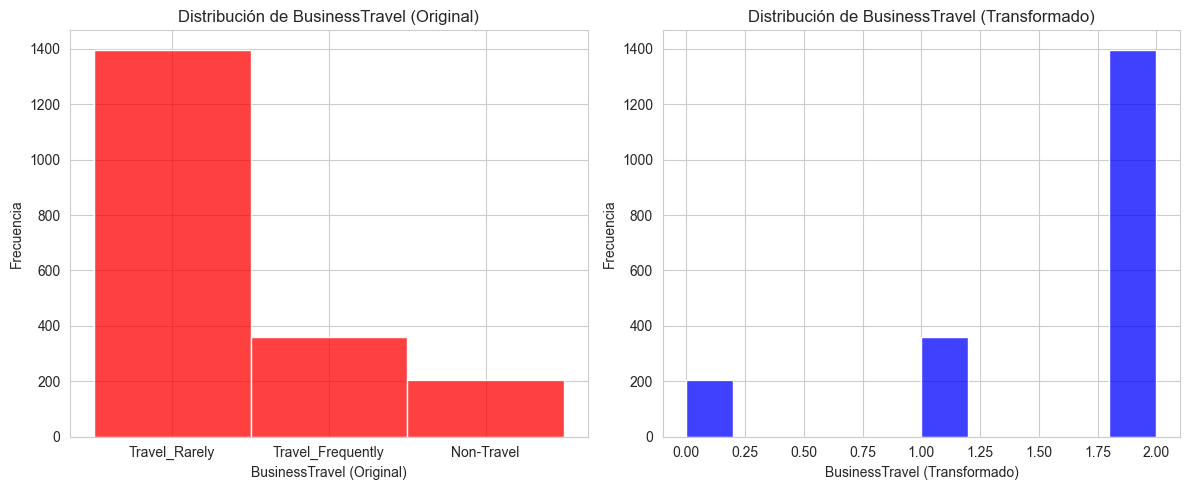

In [287]:
import matplotlib.pyplot as plt
import seaborn as sns

# Crear dos gráficos separados para visualizar la variable BusinessTravel antes y después de la transformación
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Gráfico 1: Distribución de la variable original
sns.histplot(X_train['BusinessTravel'], bins=10, color="red", ax=axes[0])
axes[0].set_xlabel("BusinessTravel (Original)")
axes[0].set_ylabel("Frecuencia")
axes[0].set_title("Distribución de BusinessTravel (Original)")
axes[0].grid(True)

# Gráfico 2: Distribución de la variable transformada
sns.histplot(X_train_transformed_df['ord__BusinessTravel'], bins=10, color="blue", ax=axes[1])
axes[1].set_xlabel("BusinessTravel (Transformado)")
axes[1].set_ylabel("Frecuencia")
axes[1].set_title("Distribución de BusinessTravel (Transformado)")
axes[1].grid(True)

plt.tight_layout()
plt.show()


# HPO con KNN


## Entrenamiento con hiperparámetros por omisión

El clasificador KNeighborsClassifier de scikit-learn tiene los siguientes parámetros por defecto:

- n_neighbors = 5
- weights = 'uniform': Todos los vecinos tienen el mismo peso (votación uniforme).
- algorithm = 'auto': Se elige automáticamente el algoritmo adecuado (ball_tree, kd_tree o brute force) según los datos.
- leaf_size = 30: Tamaño de hoja para la construcción de Ball Tree o KD Tree.
- p = 2: Se utiliza la distancia de Minkowski con  p=2 (equivalente a la distancia Euclidiana).
- metric = 'minkowski': Métrica de distancia utilizada para calcular las distancias entre puntos.
- metric_params = None: No se especifican parámetros adicionales para la métrica.
- n_jobs = None: No se usa paralelización (se ejecuta en un solo núcleo por defecto).

In [288]:
import time

knn_default = KNeighborsClassifier()  # Hiperparámetros por defecto

start_time = time.time()
knn_default.fit(X_train_transformed, y_train)
default_time_fit = time.time() - start_time

start_time = time.time()
y_pred_default = knn_default.predict(X_test_transformed)
default_time_predict = time.time() - start_time
default_score = balanced_accuracy_score(y_test, y_pred_default)

print("Modelo con hiperparámetros por omisión:")
print(f"Balanced Accuracy: {default_score:.4f}")
print(f"Tiempo de entrenamiento default: {default_time_fit:.8f} segundos")
print(f"Tiempo de predicción default: {default_time_predict:.8f} segundos")


Modelo con hiperparámetros por omisión:
Balanced Accuracy: 0.5947
Tiempo de entrenamiento default: 0.00167704 segundos
Tiempo de predicción default: 0.01250100 segundos


## Evaluación de alternativas con ajustes de hiper-parámetros

In [289]:
inner_scores_out = []

# Ahora entrenamos KNN con diferentes valores de n_neighbors
param_grid_knn = {
    'n_neighbors': [2, 3, 4, 5, 6, 7],  # Diferentes valores de vecinos
    'weights': ['uniform', 'distance'],  # Cómo se ponderan los vecinos
    'metric': ['euclidean', 'manhattan', 'minkowski'],  # Tipo de métrica
    'p': [3]
}

inner = KFold(n_splits=10, shuffle=True, random_state=72)


grid_knn = GridSearchCV(
    KNeighborsClassifier(), param_grid_knn,
    cv=inner, scoring='balanced_accuracy', n_jobs=-1, verbose=3
)

start_time = time.time()
grid_knn.fit(X_train_transformed, y_train)
hpo_time = time.time() - start_time

# Crear DataFrame con los resultados de GridSearchCV
inner_scores_df = pd.DataFrame(grid_knn.cv_results_)[
    ['param_n_neighbors', 'param_weights', 'param_metric', 'param_p', 
     'mean_test_score', 'std_test_score', 'rank_test_score']
]

# Añadir los resultados actuales a la lista
inner_scores_out.append(inner_scores_df)



Fitting 10 folds for each of 36 candidates, totalling 360 fits


In [290]:
# Obtener el mejor modelo KNN
best_knn = grid_knn.best_estimator_
start_time = time.time()
best_knn.fit(X_train_transformed, y_train)
best_knn_time = time.time() - start_time

print("\nHPO KNN:", grid_knn.best_params_)
print(f"Tiempo de entrenamiento (incluyendo HPO): {hpo_time:.2f} segundos")
print(f"Tiempo de entrenamiento utilizando el KNN con HP óptimos: {best_knn_time:.8f} segundos")
print(f"Mejora en el tiempo de entrenamiento del modelo default con respecto al modelo que utiliza los HP optimizados = {((hpo_time - best_knn_time) / hpo_time) * 100}")


HPO KNN: {'metric': 'euclidean', 'n_neighbors': 2, 'p': 3, 'weights': 'distance'}
Tiempo de entrenamiento (incluyendo HPO): 6.71 segundos
Tiempo de entrenamiento utilizando el KNN con HP óptimos: 0.00195622 segundos
Mejora en el tiempo de entrenamiento del modelo default con respecto al modelo que utiliza los HP optimizados = 99.97083022304587


Observamos que el modelo default tarda mínimo el doble de tiempo que el modelo utilizando los HP optimizados.

## Estimación de rendimiento futuro (outer)

In [291]:
from sklearn.metrics import f1_score
from sklearn import metrics

start_time = time.time()
y_pred = best_knn.predict(X_test_transformed)
pred_time = time.time() - start_time
outer_score = metrics.balanced_accuracy_score(y_test, y_pred)

print(f"Tiempo que tarda en predecir los resultados el modelo con HP optimizados: {pred_time:.8f} segundos")

print("\n**Evaluación Final en Test (Outer Loop)**")
print(f"Balanced Accuracy en Test: {balanced_accuracy_score(y_test, y_pred):.4f}")
print(f"Accuracy en Test: {accuracy_score(y_test, y_pred):.4f}")
print(f"F1-Score en Test: {f1_score(y_test, y_pred):.4f}")

# Mostrar la matriz de confusión
print("\nMatriz de Confusión:")
print(confusion_matrix(y_test, y_pred))

Tiempo que tarda en predecir los resultados el modelo con HP optimizados: 0.01239896 segundos

**Evaluación Final en Test (Outer Loop)**
Balanced Accuracy en Test: 0.8508
Accuracy en Test: 0.9255
F1-Score en Test: 0.7622

Matriz de Confusión:
[[790  32]
 [ 41 117]]


## Matriz de confusión

Vamos a visualizar la matriz de confusion en un gráfico de calor.

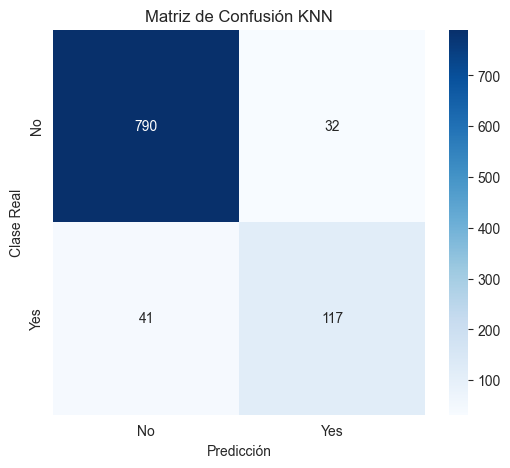

In [292]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Calcular la matriz de confusión
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['No', 'Yes'], yticklabels=['No', 'Yes'])

plt.xlabel("Predicción")
plt.ylabel("Clase Real")
plt.title("Matriz de Confusión KNN")
plt.show()


## Hiperparámetros optimizados

Representamos mediante una tabla los resultados obtenidos en el inner loop.

In [293]:

inner_scores_out_df = pd.concat(inner_scores_out, ignore_index=True)
inner_scores_out_df = inner_scores_out_df.sort_values(by='mean_test_score', ascending=False)

print("\nResultados Acumulados de Validación Cruzada")
display(inner_scores_out_df)


Resultados Acumulados de Validación Cruzada


,param_n_neighbors,param_weights,param_metric,param_p,mean_test_score,std_test_score,rank_test_score
1,2,distance,euclidean,3,0.843548,0.050731,1
3,3,distance,euclidean,3,0.841094,0.049195,2
17,4,distance,manhattan,3,0.840338,0.050655,3
25,2,distance,minkowski,3,0.838485,0.047843,4
15,3,distance,manhattan,3,0.838313,0.051421,5
13,2,distance,manhattan,3,0.837711,0.045802,6
19,5,distance,manhattan,3,0.835334,0.048053,7
5,4,distance,euclidean,3,0.833123,0.043661,8
23,7,distance,manhattan,3,0.832855,0.048691,9
21,6,distance,manhattan,3,0.831068,0.048501,10


Las filas de la tabla representan configuraciones de hiperpárametros ordenadas en orden descendente de balanced accuracy, con la mejor opción al principio. 

Aumentar el número de splits del KFold a 10 una mejor mean_test_score (debido a que se entrena con más datos en cada iteración), pero también incrementa la variabilidad (debido a que cada conjunto de prueba es más pequeño). 


## Gráfico de error

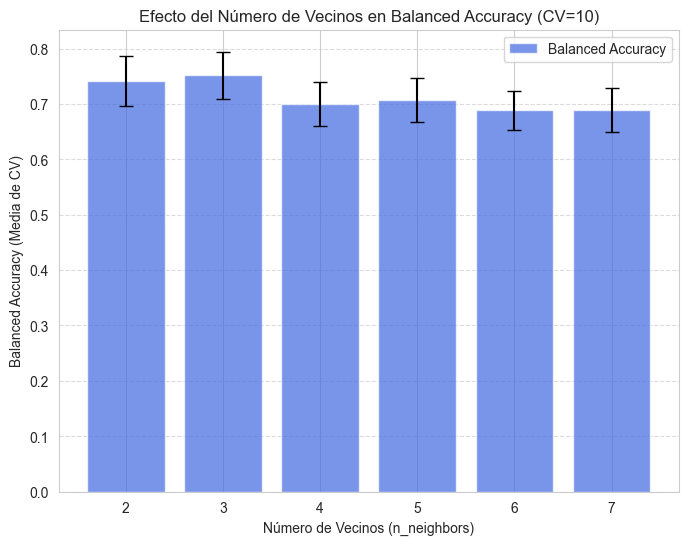

In [294]:

inner_scores_out_df = pd.concat(inner_scores_out, ignore_index=True)

grouped_scores = inner_scores_out_df.groupby('param_n_neighbors').agg(
    mean_balanced_accuracy=('mean_test_score', 'mean'),
    std_balanced_accuracy=('std_test_score', 'mean')
).reset_index()

plt.figure(figsize=(8,6))

plt.bar(grouped_scores['param_n_neighbors'], 
        grouped_scores['mean_balanced_accuracy'], 
        yerr=grouped_scores['std_balanced_accuracy'], 
        capsize=5, color='royalblue', alpha=0.7, label='Balanced Accuracy')

plt.xlabel("Número de Vecinos (n_neighbors)")
plt.ylabel("Balanced Accuracy (Media de CV)")
plt.title(f"Efecto del Número de Vecinos en Balanced Accuracy (CV={inner.get_n_splits()})")
plt.xticks(grouped_scores['param_n_neighbors'])
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend()

plt.show()


## Mapa de calor (Heatmap)

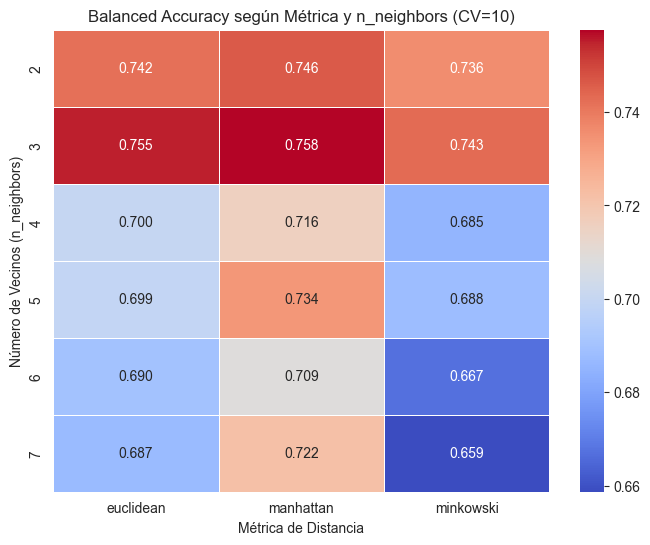

In [295]:
import seaborn as sns
import matplotlib.pyplot as plt

# Convertir la lista de resultados acumulados en un DataFrame
inner_scores_out_df = pd.concat(inner_scores_out, ignore_index=True)

# Crear una tabla pivote para el heatmap (n_neighbors vs metric) mostrando mean_test_score
heatmap_data = inner_scores_out_df.pivot_table(
    index='param_n_neighbors', columns='param_metric', values='mean_test_score', aggfunc='mean'
)

plt.figure(figsize=(8,6))
sns.heatmap(heatmap_data, annot=True, fmt=".3f", cmap="coolwarm", linewidths=0.5)

plt.xlabel("Métrica de Distancia")
plt.ylabel("Número de Vecinos (n_neighbors)")
plt.title(f"Balanced Accuracy según Métrica y n_neighbors (CV={inner.get_n_splits()})")

plt.show()
